# Conversion Rate

The goal of this project is to build a model that predicts conversion rate and, based on the model, come up with ideas or application to improve revenue.

- Goal 1: Predict conversion rate
- Goal 2: Come up with recommendations for the product team and the marketing team to improve conversion rate

## Table of Contents

- Packages and Data
- 1 - Data Exploration
- 2 - Model
- 3 - Discussion

## Packages and Data

In [1]:
import importlib
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import util_func
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
importlib.reload(util_func)

raw_data = pd.read_csv('conversion_project.csv')
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              316200 non-null  object
 1   age                  316200 non-null  int64 
 2   new_user             316200 non-null  int64 
 3   source               316200 non-null  object
 4   total_pages_visited  316200 non-null  int64 
 5   converted            316200 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


We can see that there is no NaN or null value in this dataset, and we need to further check the distribution of each variable, finding out if all the values are reasonable or other possible issues.

## Data Exploration

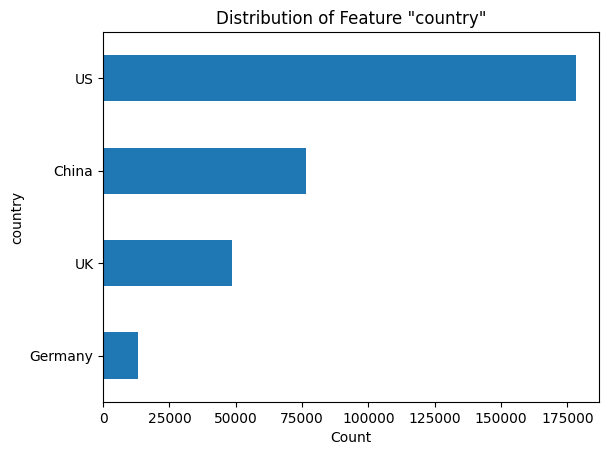

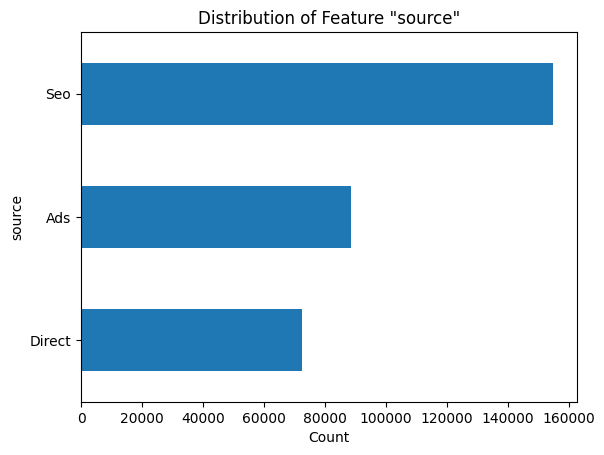

In [2]:
util_func.horizontal_barplot(raw_data['country'])
util_func.horizontal_barplot(raw_data['source'])

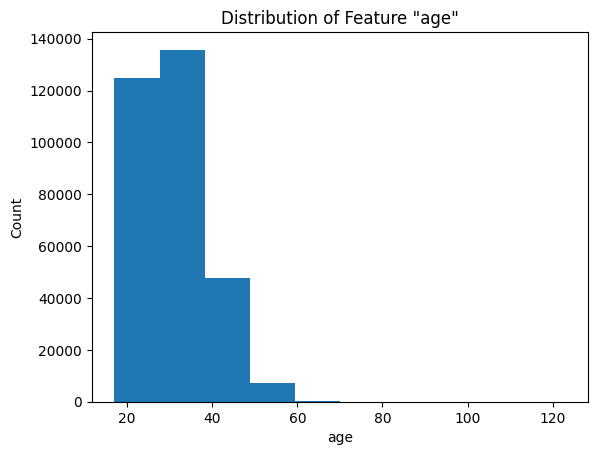

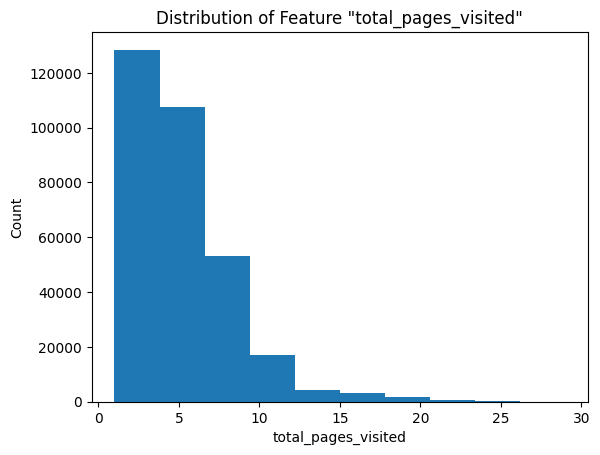

In [3]:
util_func.histogram(raw_data['age'])
util_func.histogram(raw_data['total_pages_visited'])

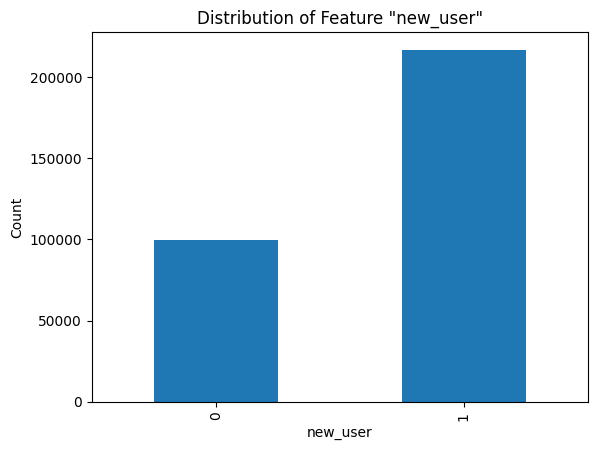

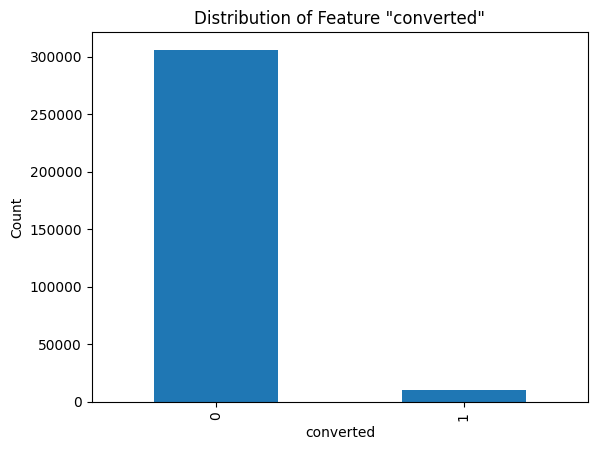

In [4]:
util_func.integer_barplot(raw_data['new_user'])
util_func.integer_barplot(raw_data['converted'])

From the plots of distribution of each variable above, two things require special attention.

1. Invalid range of variable "age"
2. Class imbalance of target variable "converted"

Let's deal with the issue from variable "age" first.

In [5]:
raw_data['age'].sort_values(ascending=False).head()

90928     123
295581    111
265167     79
192644     77
154217     73
Name: age, dtype: int64

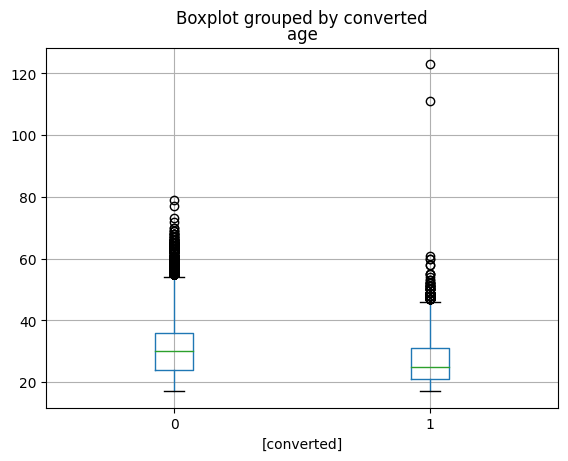

In [6]:
raw_data.boxplot('age', by=['converted'])
plt.show()

The list of the five largest "age" value shows two unreasonable values (123 and 111). Furthermore, the boxplot of "age" grouped by "converted" shows the overall pattern that the tendency of not converted among those older users. The two distinct values are not only outliers but also greatly violating the pattern of "age" against the target variable, so we should delete the two from the dataset when building the model.

In [7]:
raw_data = raw_data[~raw_data['age'].isin(raw_data['age'].nlargest(2).values)].reset_index(drop=True)

The second issue is the class imbalance of target variable "converted", which may decrease the performance or even affect the interpretation from the model. So in the model building phase we should compare the models to see if class imbalance would be an issue.

In [8]:
br = sum(raw_data['converted'] == 1) / sum(raw_data['converted'] == 0)
print('The balance ratio of target variable "converted": %.3f' % br)

The balance ratio of target variable "converted": 0.033


## Model

In order to come up ideas to improve revenue, it is crucial to identify both the effect and importance of each variable, so we select logistic regression and random forest for building the conversion rate model.

- Logistic Regression
- Random Forest

In [9]:
X = raw_data.drop(['converted'], axis=1)
y = raw_data['converted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_train = util_func.feature_engineering(X_train)
X_test = util_func.feature_engineering(X_test)

In [10]:
logistic_model = LogisticRegression(penalty='none', max_iter=500)
logistic_model.fit(X_train, y_train)

y_prediction = logistic_model.predict(X_test)
print(classification_report(y_test, y_prediction))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     91846
           1       0.85      0.68      0.76      3014

    accuracy                           0.99     94860
   macro avg       0.92      0.84      0.87     94860
weighted avg       0.99      0.99      0.99     94860



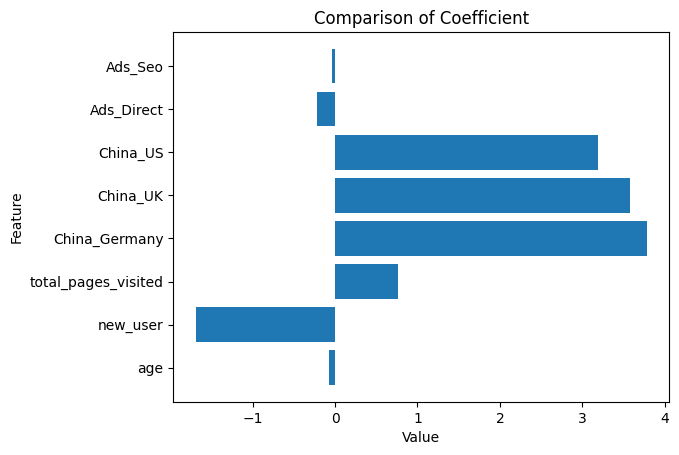

In [11]:
util_func.feature_comparison_plot(list(X_train.columns), logistic_model.coef_.flatten(), type='coefficient')

From the results of simple logistic regression model we can see the effect of each variable.

And the model performance on the test set shows that the model predicts perfectly for those not converted, but predicts not so well for those converted.

In [12]:
weight = {0: 1, 1: 2}
weighted_logistic_model = LogisticRegression(penalty='none', class_weight=weight, max_iter=300)
weighted_logistic_model.fit(X_train, y_train)

y_prediction = weighted_logistic_model.predict(X_test)
print(classification_report(y_test, y_prediction))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     91846
           1       0.76      0.75      0.76      3014

    accuracy                           0.98     94860
   macro avg       0.88      0.87      0.88     94860
weighted avg       0.98      0.98      0.98     94860



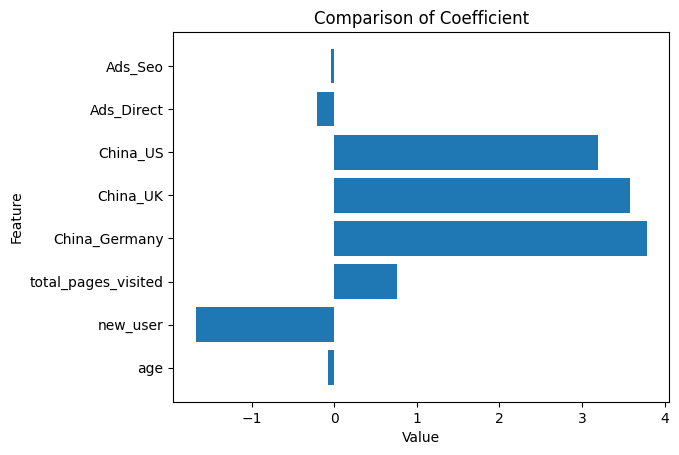

In [13]:
util_func.feature_comparison_plot(list(X_train.columns), weighted_logistic_model.coef_.flatten(), type='coefficient')

So now we want to quickly try if there is a better model to address the class imbalance issue, and also check the coefficient is robust under this condition.

After try different class weight, we notice that there is a growth and decline between recall and precision, but the overall performance seems not increase, and the coefficient is quite stable.

Let’s try a more complicated model to see if the performance on test set would increase.

In [14]:
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)

y_prediction = random_forest.predict(X_test)
print(classification_report(y_test, y_prediction))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     91846
           1       0.81      0.67      0.74      3014

    accuracy                           0.98     94860
   macro avg       0.90      0.83      0.86     94860
weighted avg       0.98      0.98      0.98     94860



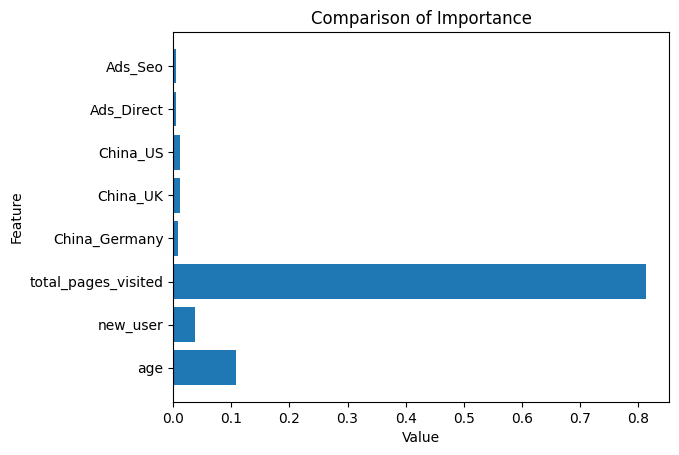

In [15]:
util_func.feature_comparison_plot(list(X_train.columns), random_forest.feature_importances_, type='importance')

From the result we can see that it performs almost the same with logistic regression. But from the importance plot it shows that “total_pages_visited” is the much more important variable.

## Discussion

Let's discuss the results above from three aspect: output/performance of models, insights from models and possible actions to take.

- output/performance of models

From the performance of predicted converted and the batch conversion rate prediction, the two model almost the same. For the sake of model simplicity, it is better to build the conversion rate model using logistic regression.

- insights from models

It seems that the insights from the model (coefficient from logistic regression & importance from random forest) contradict themselves. After considering the scale of each variable, the two in fact tell the same story.

Though from the plot of comparison of coefficient, is seems that dummy variables from “source” have quite large coefficient, but actually the difference between these dummy variance is quite small. Also the scale of these variable is only one, and the variable of original variance of distributed to three different dummy variables. That’s why these three is having high coefficient but very low importance.

On the other hand, though “total_pages_visited” and age is having relatively low coefficient, but the scale of the two is quite larger than the others, so their coefficient can be multiplied to make an larger effect, especially for the “total_pages_visited”.

To sum up, insight from logistic regression shows the net effect of each variable, while insight from random forest tell us which variable is more dominant to the target variable.

- possible actions to take

From the model we built, we can simply conclude that total_pages_visited is a critical variable affecting whether a user convert or not. So the product and marketing team should try their best to keep users staying longer on their website.

Though the initial intent of building the conversion model is to perform batch conversion rate prediction, such application fails to react timely based on whether a single user is becoming more likely to convert. From the marketing aspect, if we can know that a user is around 40% to 50% to convert, then marketing team can take special action trying to keep this user. In this way, marketing team can design different strategy for different type of user, and maybe don’t have to put too much focus on those user with too lower probability of conversion. Or if we can know that a given user become a user with high conversion rate, then we can do something special to this user to increase revenue.

How can we build this application?

Since all the variables except for total_pages_visited are determined at the time users come in, so we can calculate the “total_pages_visited” required to achieve certain probability to convert. In this way marketing team can adaptively and automatically take different actions for different level of probability, just to keep to users on the website.